# Introduction

This notebook contains a variety of models that tackle the problem of creating a character-based language-model out of the full set of FAA regulations. The final and best performing model is then used to generate new text in the style of the corpus of regulations it has been trained on - **a new regulations generator!**

The FAA is the US federal agency responsible for regulating the entire civil aviation sector in the country. It oversees everything from aircraft certification to air traffic control, airmen qualifications, flight operations, aircraft maintenance and much more.

In this project, we download the full set of regulations under the FAA responsibility directly from the e-CFR (electronic Code of Federal Regulations). The .xml file is processed and split into a _train_, a _validation_ and a _test_ .txt files, which are then used to train and evaluate a Recurrent Neural Network model that receives a sequence of characters as input and outputs a prediction for the next character in the sequence.

Here are a few features that are explored in the sections below:

* Human performance is evaluated as a benchmark by presenting a series of short sequences of text and requesting a guess as to what would be the next character. Upon trying it for a few hundred attemps, I was able to correctly guess the next character around 65% of the times.

* A _tokenizer_ object is used to create a dictionary with every character found in the text corpus. This dictionary is then used to feed into two different encoding approaches:   
    1. One-hot encoding, in which a vector of the same size as the dictionary is created for each input and the position corresponding to the character in the input is set to 1, while all others are set to 0;
    2. Character embedding, in which a trainable dense representation of the characters is created, with a dimension smaller than the size of the dictionary.

* A function is created to prepare the dataset according to parameters such as the chosen encoding, batch size, sequence length and the statefulness status of the RNN.

* A model with _null_ input (every input character set to zero) is created in order to set the performance benchmark and determine the prevalence of each of the characters in the dictionary.

* A simple one-to-one (non-recurrent) model is also trained as a benchmark.

* Different types of recurrent units are experimented with: the SimpleRNN, GRU and LSTM built-in units from _keras_, as well as custom GRU and LSTM units paired with a layer normalization layer.

* The length of the sequences to which each instance of the RNN is exposed is carefully chosen (together with the batch size) to maximize the sequence length (so the network can try and learn longer relationships and patterns), while respecting memory restrictions and a reasonable training time.

* The final and best performing model is composed of a stack of 3 GRUs with 580 units, with layer normalization and a dense sofmax layer on top, regularized with dropout (both vertical and horizontal), with a sequence length of 512 characters. The RNN is configured as _stateful_, meaning that the memory cells are not erased after each gradient descent iteration.

* With the _stateful_ configuration, the RNN can propagate information indefinetely. However, because it was trained with a sequence length of 512, backpropagation is not able to_teach_ the network to actively learn to preserve longer patterns. In other words, the network _stores_ patterns in longer sequences, but it was not taught to _actively memorize_ patterns that might be useful more than 512 characters in the future.

* Every one of the models used in the work are character-based. At this time, there were no experiments with word embeddings, which could potentially have a dramatic improvement in performance. Nevertheless, the results are quite remarkable considering that the model has no prior knowledge of the _semantics_ of the text whatsoever.

Finally, you are encouraged to use this code any way you want. You _**are not**_ encouraged to try to train any of these models without a GPU!

# Setup

## Import packages

Besides the usual suspects, we use the _xml.etree.ElementTree_ Python model to process the .xml file obtained from the e-CFR.

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

import xml.etree.ElementTree as ET
from os import listdir, mkdir, getcwd, chdir
from os.path import join

import time
import json
import pickle

##Download and split data
* The .xml file is downloaded directly from the e-CFR website using the _wget_ command and is saved to the _dataset_ directory.

The file is then processed with the _xml.etree.ElementTree_ module. Not all volumes of Title 14 of the Code of Federal Regulations are related to civil aviation (there are also DOT and NASA volumes), so they are not saved in the dataset.

The full text is split into a _train_, a _validation_ and a _test_ sets in a proportion of 98/1/1%. The code also allows for a _trash_ file to be created to allow for some experimentation with smaller datasets.

The division is done section by section, so that paragraphs are not split during the partitioning of the dataset.

In [ ]:
if 'dataset' not in listdir():
  mkdir('dataset')

working_directory = getcwd()
chdir(join(working_directory, 'dataset'))
!wget https://www.govinfo.gov/bulkdata/ECFR/title-14/ECFR-title14.xml
chdir(working_directory)

--2021-03-27 14:16:55--  https://www.govinfo.gov/bulkdata/ECFR/title-14/ECFR-title14.xml
Resolving www.govinfo.gov (www.govinfo.gov)... 104.16.165.242, 104.16.164.242, 2606:4700::6810:a4f2, ...
Connecting to www.govinfo.gov (www.govinfo.gov)|104.16.165.242|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16492972 (16M) [text/xml]
Saving to: ‘ECFR-title14.xml.3’

ECFR-title14.xml.3  100%[===================>]  15.73M   845KB/s    in 19s     

2021-03-27 14:17:15 (829 KB/s) - ‘ECFR-title14.xml.3’ saved [16492972/16492972]



In [ ]:
# set the random seed for the train/valid/test/trash split
np.random.seed(20210228)

# access the unprocessed xml file
filepath = join('dataset', 'ECFR-title14.xml') # file already fetched from https://www.govinfo.gov/bulkdata/ECFR/title-14/ECFR-title14.xml
tree = ET.parse(filepath) # set up a xml tree by parsing the file
root = tree.getroot() # get a reference to the tree root

# create new files for each partition
train = open(join('dataset','ECFR-title14-train.txt'), 'w', encoding='utf-8')
valid = open(join('dataset','ECFR-title14-valid.txt'), 'w', encoding='utf-8')
test = open(join('dataset','ECFR-title14-test.txt'), 'w', encoding='utf-8')
trash = open(join('dataset', 'trash.txt'), 'w', encoding='utf-8')

# set up train/valid/test split scheme
partitions = np.array(['train', 'valid', 'test', 'trash'])
next_partition = partitions[0]
split_proportions = np.array([.98, .01, .01, 0]) # train, valid, test, trash

# iterate over each element of the xml tree
for element in root.iter():
    # stop when DoT part is reached
    if element.tag == 'DIV1':
        if element.attrib['N'] == '4':
            break 
        # if reached a new section
    if element.tag == 'DIV8':
        if next_partition == 'train':
            [train.write(line) for line in element.itertext() if line[0] != '\n']
        elif next_partition == 'valid':
            [valid.write(line) for line in element.itertext() if line[0] != '\n']
        elif next_partition == 'test':
            [test.write(line) for line in element.itertext() if line[0] != '\n']
        elif next_partition == 'trash':
            [trash.write(line) for line in element.itertext() if line[0] != '\n']
        next_partition = np.random.choice(partitions, p = split_proportions)

# close the newly created files
train.close()
valid.close()
test.close()
trash.close()

## Set up the datasets

The function _make_dataset_ sets up each of the partitions in a _Dataset_ object from the _TensorFlow_ _data_ API. The datasets are batched according the the selection of the sequence length and batch size.

A few different modes are also implemented, depending on the type of model that will be used. The shape of the inputs is dependent on whether they will be fed into a dense non-recurrent network, a recurrent network with one-hot encoding or character embedding, or a stateful recurrent network.

The preparation of the dataset for use with the stateful model is particularly demanding. It is fundamental to make that each instance of the network is fed always fed with a sequence that is the continuation of the previous sequence. When doing training with multiple batches, this requires batching and interleaving the pieces in a very particular order.

In [ ]:
def make_dataset(partition, tokenizer, sequence_length = None, batch_size = 16, dummy = False, batching_mode = 'regular'):
    
    assert batching_mode in ['regular', 'recurrent_encoding', 'recurrent_embedding', 'stateful_encoding']

    # get dataset as list of sequences of tokens
    with open(join('dataset', 'ECFR-title14-' + partition + '.txt'), encoding='utf-8') as file:
        sequences = tokenizer.texts_to_sequences(file)
    
    # make single stream of tokens for the entire dataset
    dataset = [] 
    for paragraph in sequences:
        dataset += paragraph
    
    # get x and y from the full sequence
    dataset = np.array(dataset)
    y = tf.data.Dataset.from_tensor_slices(dataset[1:])
    
    # in case of a dummy dataset (x is all null)
    if dummy == True:  # empty inputs in order to test setup
        x = tf.data.Dataset.from_tensor_slices(np.zeros_like(dataset[:-1]))
    else:
        x = tf.data.Dataset.from_tensor_slices(dataset[:-1])
    
    # zip inputs and labels into tuples
    if batching_mode == 'regular': # dataset will not be batched into sequences (for simple NN)
        dataset = tf.data.Dataset.zip((x,y))
        dataset = dataset.batch(batch_size)
    elif batching_mode == 'recurrent_encoding': # will be batched in individual entries, then sequences, then batches
        dataset = tf.data.Dataset.zip((x,y))
        dataset = dataset.batch(1)
        dataset = dataset.batch(sequence_length, drop_remainder = True)
        dataset = dataset.batch(batch_size, drop_remainder = True)
    elif batching_mode == 'recurrent_embedding': # will be batched into sequences, then batches
        dataset = tf.data.Dataset.zip((x,y))
        dataset = dataset.batch(sequence_length, drop_remainder = True)
        dataset = dataset.batch(batch_size, drop_remainder = True)
    elif batching_mode == 'stateful_encoding': # will be batch so there is a stream of characters from a few longer sequences, compatible with stateful RNN
        
        partition_length = len(dataset)

        # batch_size = number of RNN instances, each seeing a piece from a different paragraph
        num_paragraphs = batch_size # different name for the same thing
        paragraph_length = partition_length // num_paragraphs # characters in each of the batch_size paragraphs
        # sequence_length = number of characters in a sequence = number of repetitions of the RNN stack per instance
        sequences_per_paragraph = paragraph_length // sequence_length # number of steps to finish paragraph = steps per epoch
        
        def map_fn(paragraph):
            return tf.data.Dataset.from_tensor_slices(paragraph).batch(sequence_length, drop_remainder=True)
        
        x = x.batch(1)
        x = x.batch(paragraph_length, drop_remainder = True)
        x = x.interleave(map_fn, cycle_length = num_paragraphs)
        x = x.batch(batch_size, drop_remainder = True)
        
        y = y.batch(1)
        y = y.batch(paragraph_length, drop_remainder = True)
        y = y.interleave(map_fn, cycle_length = num_paragraphs)
        y = y.batch(batch_size, drop_remainder = True)
        
        dataset = tf.data.Dataset.zip((x, y))
      
    dataset = dataset.prefetch(1)
    
    return dataset

## Create a tokenizer instance and fit to train set

A _tokenizer_ object is then fit to the corpus of text. If will be provided as input to the _make_dataset_ function and will be used to translate the characters into integer numbers according the a dictionary constructed via the _fit_on_texts()_ method.

In [ ]:
tokenizer = keras.preprocessing.text.Tokenizer(char_level = True, lower = False, filters = '')

for partition in ['train', 'valid', 'test']:
    file = open(join('dataset', 'ECFR-title14-'+ partition + '.txt'), encoding = 'utf-8')
    tokenizer.fit_on_texts(file)
    file.close()

## Test the dataset for stateful RNN

This piece of code displays an excerpt of the dataset when prepared for training a stateful RNN. In this setup, the dataset is split into multiple batches of 4 sequences of length 48 each.

Here we see 6 of this batches. Notice that the first sequence of the first, second, third etc batches are pieces of the same sentence. The same goes for the second sequence and so on. This means that each instance of the RNN will be trained with a continuation of the sentence it just saw in the previous gradient descent step.

In [ ]:
sequence_length = 48
batch_size = 4

train = make_dataset('train', tokenizer, sequence_length = sequence_length, 
                     batch_size = batch_size, batching_mode = 'stateful_encoding')

for item in train.take(6):
    for sequence in range(len(item[0].numpy())):
        text = tokenizer.sequences_to_texts([item[0].numpy()[sequence].squeeze()])[0][::2]
        text = text.replace('\n', '')
        print(text)
    print()

§ 1.1   General definitions.Link to an amendment
otor r.p.m. for which certification is requested
 replacement can be made. (4) If the aircraft i
storage medium. The parameters specified in appe

 published at 86 FR 4503, Jan. 15, 2021.Link to 
; and (4) For power-off operations, under any c
s operated for hire, one electric landing light.
ndix D of this part must be recorded within the 

an extension of the above amendment published at
ondition of speed, and rotor r.p.m. for which ce
 (5) An adequate source of electrical energy fo
ranges, accuracies, resolutions and sampling int

 86 FR 13629, Mar. 10, 2021.As used in Subchapte
rtification is requested that is attainable with
r all installed electrical and radio equipment. 
ervals specified. For the purpose of this sectio

rs A through K of this chapter, unless the conte
 the controls rigged in accordance with the appr
(6) One spare set of fuses, or three spare fuse
n, “manufactured” means the point in time at whi

xt requires otherwi

## Helper functions

Some helper functions are defined to print the model performance in a standardized manner and plot a figure with the evolution of its loss and performance metric during training. Another function is defined to create an unique name for a directory for performance logging for usage with _TensorBoard_.

In [ ]:
def print_performance(model, log_dir=None):
    print("Performance on train set:")
    perf_train = model.evaluate(train)

    print("Performance on valid set:")
    perf_valid = model.evaluate(valid)

    print("Performance on test set:")
    perf_test = model.evaluate(test)
    
    if log_dir == None:
        directory = "-"
    else:
        directory = log_dir.rpartition('\\')[2]

    print("Performance log:")
    log = '{} | {} | {} | {} {} {} | {}% {}% {}%'.format(directory, model.name, model.count_params(),
                                               round(perf_train[0],3), round(perf_valid[0],3), round(perf_test[0],3),
                                               round(perf_train[1]*100,1),round(perf_valid[1]*100,1),round(perf_test[1]*100,1))
    print(log)
    
    return None
    
def print_history(history):    
    plt.figure(figsize=(15,3))

    plt.subplot(1,2,1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss: categorical cross-entropy')

    plt.subplot(1,2,2)
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('metric: sparse categorical accuracy')
    
    return None

def get_tensorboard_logdir():
    run_id = time.strftime("run__%Y-%m-%d__%H-%M-%S")
    return join(getcwd(), 'tb_logs', run_id)

## Custom recurrent layers with Layer Normalization

Layer normalization is a game-changing technique for stabilizing the training of RNNs with long sequences of inputs.

While both the layer normalization layer and the GRU and LSTM layers are built-in to _keras_, there is currently no straighforward way to apply layer normalization to a recurrent unit. In order to do so, custom RNN cells are required.

The classes defined below implement both GRU and LSTM cells with layer normalization.

In [ ]:
class LN_GRU_Cell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", dropout=0, recurrent_dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.state_size = units
        self.output_size = units
        self.GRU_cell = keras.layers.GRUCell(units, dropout=dropout, recurrent_dropout=recurrent_dropout, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        outputs, new_states = self.GRU_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [new_states]
    def get_config(self):
        base_config = super().get_config()
        custom_config = {'units':self.units,
                         'dropout':self.dropout,
                         'recurrent_dropout':self.recurrent_dropout,
                         'activation':self.activation}
        return {**base_config, **custom_config}
    
class LN_LSTM_Cell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", dropout=0, recurrent_dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.dropout = dropout
        self.recurrent_dropout = recurrent_dropout
        self.state_size = [units, units]
        self.output_size = units
        self.LSTM_cell = keras.layers.LSTMCell(units, dropout=dropout, recurrent_dropout=recurrent_dropout, activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        memory_states, carry_states = states
        outputs, new_states = self.LSTM_cell(inputs, [memory_states, carry_states])
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [new_states]
    def get_config(self):
        base_config = super().get_config()
        custom_config = {'units':self.units,
                         'dropout':self.dropout,
                         'recurrent_dropout':self.recurrent_dropout,
                         'activation':self.activation}
        return {**base_config, **custom_config}

# Evaluate human performance

It is usually interesting to assess how well humans perform on a certain task before trying to build a model for that same task. In order to do so, the code below challenges the user to try and guess what is the next character after a text excerpt has been presented.

To avoid confusion with excerpts ending in spaces, all spaces are substituted with a '_' character.

After a few hundred guesses, I was able to reach around 65% accuracy.

In [ ]:
 with open(join('dataset','ECFR-title14-train.txt'), 'r', encoding = 'UTF-8') as file:
    corpus = file.read()

excerpt_length = 128
correct_letter = []
user_guess = []
end_of_excerpt = []

print('HUMAN PERFORMANCE EVALUATION')
print('How many attemps are you interested in taking?')
user_input = input()
print()

try:
    num_attempts = int(user_input)
except:
    num_attempts = 0

for attempt in range(num_attempts):
    print('Attempt # {}/{}: '.format(str(attempt+1).rjust(len(str(num_attempts)),'0'), num_attempts))
    start = np.random.randint(low = 0, high = len(corpus) - excerpt_length)
    excerpt = corpus[start:start+excerpt_length]
    print(excerpt[:-1].replace(' ', '_'))
    end_of_excerpt.append(excerpt[-16:-1])
    correct_letter.append(excerpt[-1])
    user_guess.append(input())
    print()

for attempt in range(num_attempts):
    print('Attempt # {}/{}: '.format(str(attempt+1).rjust(len(str(num_attempts)),'0'), num_attempts), end='')
    print('{}({})[{}]'.format(end_of_excerpt[attempt].replace('\n',' '), correct_letter[attempt], user_guess[attempt]), end='')
    if correct_letter[attempt] == user_guess[attempt]:
        print(' - CORRECT')
    else:
        print(' - WRONG')

print('\nUser accuracy: {}'.format((np.array(correct_letter) == np.array(user_guess)).mean()))

HUMAN PERFORMANCE EVALUATION
How many attemps are you interested in taking?
10

Attempt # 01/10: 
ers_control_more_than_50_percent_of_passenger_boardings.
Debt_service_means_payments_for_such_items_as_principal_and_interest,_
n

Attempt # 02/10: 
cate_holder_described_in_paragraph_(a)(1)_of_this_section_may_not,_after_March_20,_1997,_operate_an_airplane_described_in_parag
r

Attempt # 03/10: 
or_also_means_any_representative_of_the_aircraft_owner,_or_in_the_case_of_a_leased_aircraft,_any_representative_of_the_lessee_e
n

Attempt # 04/10: 
approved_airport_layout_plan.
(d)_The_airport_involved_in_a_project_for_airport_development_must_be_included_in_the_current_NAS
 

Attempt # 05/10: 
ith_the_limitations_in_the_operations_specifications._
[Doc._No._6258,_29_FR_19219,_Dec._31,_1964,_as_amended_by_Amdt._121-253,
 

Attempt # 06/10: 
sed_approach_below_the_minimum_engagement_altitude_specified_for_takeoff_and_initial_climb_in_paragraph_(b)_in_this_section._An
 

Attempt # 07/10: 
_the_run

# Models

A healthy practice when developing complex models is to start with a rudimentary version and to incrementaly add more elements. This stepwise approach provides transparency as to what each piece of the model provides in terms of performance and allows for more control when deciding which pieces to add. Ideally, no complexity should be included in the model unless it improves performance.

## Dummy model with null input

We begin modeling by constructing a dummy model. In this setup, the dataset features in the dataset are replaced with a stream of zeros. A densely connected layer with softmax activation is used to learn the biases corresponding the frequency of each of the characters in the dataset.

Here are some of the features of this model:

* Given a null input, predict next character
* Gradients for the weights will always be null
* This setup will only learn the bias, which can then be used as initialization for the bias on the last layer of the subsequent models
* Avoids hockey-stick learning curves
* Learning rate can be set up on next models according to a phase when the network is actually learning patterns in the data
* Training for a single epoch is sufficient for dense layer to learn the biases.

Additionaly, the value for the loss and metrics obtained in this manner serve as an important performance benchmark - any model that is effectively able to extract information from the inputs should be able to beat these values.

In [ ]:
batch_size = 128
dict_size = len(tokenizer.index_word.keys()) + 1
lr_0 = .5
epochs = 1

In [ ]:
train_dummy = make_dataset('train', tokenizer, batch_size = batch_size, dummy = True)
train = make_dataset('train', tokenizer, batch_size = batch_size)
valid = make_dataset('valid', tokenizer)
test = make_dataset('test', tokenizer)

In [ ]:
model = keras.models.Sequential(name = "Dummy_Classifier")

model.add(keras.layers.Input(shape = (1), name = 'Input')) # add None to first dimension when using RNN
model.add(keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = dict_size, name = 'Encoding'))
model.add(keras.layers.Dense(units = dict_size, activation = 'softmax', name = 'Output'))

model.compile(optimizer = keras.optimizers.SGD(learning_rate = lr_0), 
              loss = 'sparse_categorical_crossentropy', metrics = 'sparse_categorical_accuracy')

model.summary()

Model: "Dummy_Classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoding (CategoryEncoding)  (None, 116)               0         
_________________________________________________________________
Output (Dense)               (None, 116)               13572     
Total params: 13,572
Trainable params: 13,572
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train_dummy, epochs = 1, verbose = 0)

In [ ]:
print_performance(model)

Performance on train set:
52369/52369 [==============================] - 99s 2ms/step - loss: 3.4713 - sparse_categorical_accuracy: 0.1204
Performance on valid set:
4270/4270 [==============================] - 7s 2ms/step - loss: 3.4557 - sparse_categorical_accuracy: 0.1201
Performance on test set:
3776/3776 [==============================] - 6s 2ms/step - loss: 3.4487 - sparse_categorical_accuracy: 0.1254
Performance log:
- | Dummy_Classifier | 13572 | 3.471 3.456 3.449 | 12.0% 12.0% 12.5%


Here, the biases in the output layer are saved to the _bias_output_layer_ variable. This vector will be used as the initialization for the output layer for the next models.

In [ ]:
bias_output_layer = model.layers[-1].get_weights()[1]

## Simple model with one-hot encoded input

* Given a single character, one-hot encode and predict the next one
* Encoding layer followed by Dense layer with softmax activation

In [ ]:
batch_size = 128
dict_size = len(tokenizer.index_word.keys()) + 1
lr_0 = 1
epochs = 50

In [ ]:
train = make_dataset('train', tokenizer, batch_size = batch_size)
valid = make_dataset('valid', tokenizer)
test = make_dataset('test', tokenizer)

In [ ]:
model = keras.models.Sequential(name = "Softmax_Classifier_with_Encoding")

model.add(keras.layers.Input(shape = (1), name = 'Input')) # add None to first dimension when using RNN
model.add(keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = dict_size, name = 'Encoding'))
model.add(keras.layers.Dense(units = dict_size, activation = 'softmax', name = 'Output',
                             bias_initializer = keras.initializers.Constant(bias_output_layer)))

model.compile(optimizer = keras.optimizers.SGD(learning_rate = lr_0), 
              loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 1, restore_best_weights = True, verbose = True)

model.summary()

Model: "Softmax_Classifier_with_Encoding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoding (CategoryEncoding)  (None, 116)               0         
_________________________________________________________________
Output (Dense)               (None, 116)               13572     
Total params: 13,572
Trainable params: 13,572
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train, epochs = epochs, verbose = 0, validation_data = valid,
                   callbacks = [early_stopping_cb])

Performance on train set:
52300/52300 [==============================] - 71s 1ms/step - loss: 2.4818 - sparse_categorical_accuracy: 0.2542
Performance on valid set:
4270/4270 [==============================] - 4s 871us/step - loss: 2.4581 - sparse_categorical_accuracy: 0.2539
Performance on test set:
3776/3776 [==============================] - 3s 869us/step - loss: 2.4617 - sparse_categorical_accuracy: 0.2598
Performance log:
- | Softmax_Classifier_with_Encoding | 2.482 2.458 2.462 | 25.4% 25.4% 26.0%


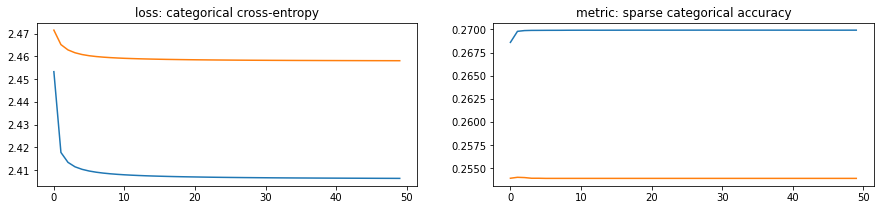

In [ ]:
print_performance(model)
print_history(history)

## Simple model with embedded input

* Given a single character, apply embedding and predict the next character
* Embedding layer followed by Dense layer with softmax activation

In [ ]:
batch_size = 128
dict_size = len(tokenizer.index_word.keys()) + 1
embedding_dim = 10
lr_0 = 1
epochs = 50

In [ ]:
train = make_dataset('train', tokenizer, batch_size = batch_size)
valid = make_dataset('valid', tokenizer)
test = make_dataset('test', tokenizer)

In [ ]:
model = keras.models.Sequential(name = "Softmax_Classifier_with_Embedding")

model.add(keras.layers.Embedding(input_dim = dict_size, output_dim = embedding_dim, input_length = 1, name = 'Embedding'))
model.add(keras.layers.Dense(units = dict_size, activation = 'softmax', name = 'Output',
                             bias_initializer = keras.initializers.Constant(bias_output_layer)))

model.compile(optimizer = keras.optimizers.SGD(learning_rate = lr_0), 
              loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 1, restore_best_weights = True, verbose = True)

model.summary()

Model: "Softmax_Classifier_with_Embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 1, 10)             1160      
_________________________________________________________________
Output (Dense)               (None, 1, 116)            1276      
Total params: 2,436
Trainable params: 2,436
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train, epochs = epochs, verbose = 0, validation_data = valid,
                   callbacks = [early_stopping_cb])

Restoring model weights from the end of the best epoch.
Epoch 00004: early stopping


Performance on train set:
52300/52300 [==============================] - 76s 1ms/step - loss: 2.5773 - sparse_categorical_accuracy: 0.2419
Performance on valid set:
4270/4270 [==============================] - 4s 923us/step - loss: 2.5466 - sparse_categorical_accuracy: 0.2427
Performance on test set:
3776/3776 [==============================] - 4s 927us/step - loss: 2.5516 - sparse_categorical_accuracy: 0.2443
Performance log:
- | Softmax_Classifier_with_Embedding | 2.577 2.547 2.552 | 24.2% 24.3% 24.4%


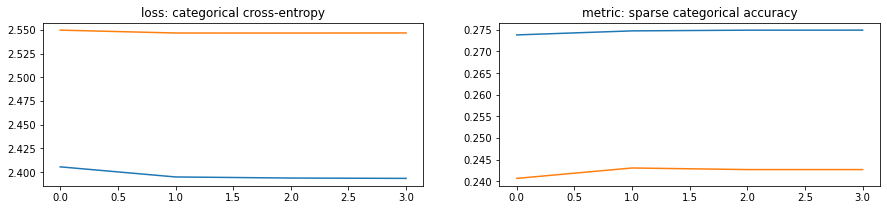

In [ ]:
print_performance(model)
print_history(history)

## RNNs with single recurrent unit and one-hot encoding

* Many-to-many setup: the network tries to predict the entire sequence of characters.
* Single recurrent unit.
* Code available for all three built-in recurrent units: Simple recurrent unit & GRU & LSTM (uncomment appropriate line to chose which one to use).
* One-hot encoding layer is wrapped by a time distributed layer.
* Default GRU and LSTM implementations use the same bias_initializer for the kernel and recurrent channels. Bias initialization with the biases obtained from the dummy model requires accessing the right part of the bias vector (not implemented here).

In [ ]:
sequence_length = 32
batch_size = 128
dict_size = len(tokenizer.index_word.keys()) + 1
lr_0 = .01
epochs = 100

In [ ]:
train = make_dataset('train', tokenizer, sequence_length = sequence_length, batch_size = batch_size, batching_mode = 'recurrent_encoding')
valid = make_dataset('valid', tokenizer, sequence_length = sequence_length, batching_mode = 'recurrent_encoding')
test = make_dataset('test', tokenizer, sequence_length = sequence_length, batching_mode = 'recurrent_encoding')

In [ ]:
encoding = keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = dict_size, name = "Encoding")
td_encoding = keras.layers.TimeDistributed(encoding, input_shape = [None, 1], name = "TD_Encoding")

simple_rnn = keras.layers.SimpleRNN(units = dict_size, return_sequences = True, activation = 'softmax', 
                                    bias_initializer = keras.initializers.Constant(bias_output_layer),
                                    name = "Recurrent")
gru = keras.layers.GRU(units = dict_size, return_sequences = True, activation = 'softmax', 
                       name = "Recurrent")
lstm = keras.layers.LSTM(units = dict_size, return_sequences = True, activation = 'softmax', 
                         name = "Recurrent")

#model = keras.models.Sequential([td_encoding, simple_rnn], name = "Simple_RNN_with_Encoding")
#model = keras.models.Sequential([td_encoding, gru], name = "GRU_with_Encoding")
model = keras.models.Sequential([td_encoding, lstm], name = "LSTM_with_Encoding")

model.compile(optimizer = keras.optimizers.Adam(learning_rate = lr_0), 
              loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True, verbose = True)
log_dir = get_tensorboard_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(log_dir = log_dir)

model.summary()

Model: "LSTM_with_Encoding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
TD_Encoding (TimeDistributed (None, None, 116)         0         
_________________________________________________________________
Recurrent (LSTM)             (None, None, 116)         108112    
Total params: 108,112
Trainable params: 108,112
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train, epochs = epochs, verbose = 0, validation_data = valid,
                   callbacks = [early_stopping_cb, tensorboard_cb])

Here we see a significant improvement in performance in comparison with the simpler models that only took one character into account when predicting the next one.

Performance on train set:
1634/1634 [==============================] - 73s 44ms/step - loss: 2.0464 - sparse_categorical_accuracy: 0.4189 5s - loss: 2.0442 - sparse_categorical_accurac - ETA: 4s
Performance on valid set:
133/133 [==============================] - 1s 11ms/step - loss: 1.9878 - sparse_categorical_accuracy: 0.4347
Performance on test set:
117/117 [==============================] - 1s 10ms/step - loss: 2.0544 - sparse_categorical_accuracy: 0.4051
Performance log:
run__2021-03-03__12-56-16 | LSTM_with_Encoding | 2.046 1.988 2.054 | 41.9% 43.5% 40.5%


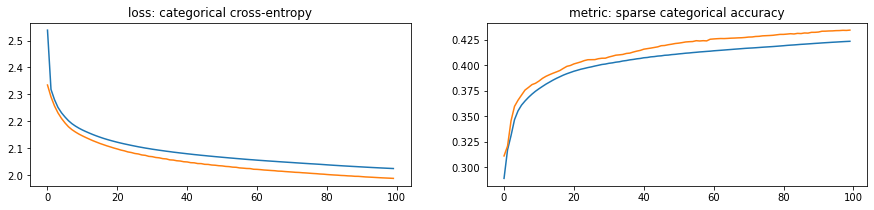

In [ ]:
print_performance(model, log_dir)
print_history(history)

## RNN with single recurrent unit and embedding

* Same setup as above, but with and embedding instead of encoding.
* The embedding layer does not require wrapping with a time distributed layer.

In [ ]:
sequence_length = 32
batch_size = 128
dict_size = len(tokenizer.index_word.keys()) + 1
embedding_dim = 20
lr_0 = .01
epochs = 100

In [ ]:
train = make_dataset('train', tokenizer, sequence_length = sequence_length, batch_size = batch_size, batching_mode = 'recurrent_embedding')
valid = make_dataset('valid', tokenizer, sequence_length = sequence_length, batching_mode = 'recurrent_embedding')
test = make_dataset('test', tokenizer, sequence_length = sequence_length, batching_mode = 'recurrent_embedding')

In [ ]:
embedding = keras.layers.Embedding(input_dim = dict_size, output_dim = embedding_dim, name = "Embedding", input_shape=[None])
recurrent = keras.layers.SimpleRNN(units = dict_size, return_sequences = True, activation = 'softmax', 
                                   bias_initializer = keras.initializers.Constant(bias_output_layer),
                                   name = "Recurrent")

simple_rnn = keras.layers.SimpleRNN(units = dict_size, return_sequences = True, activation = 'softmax', 
                                   bias_initializer = keras.initializers.Constant(bias_output_layer),
                                   name = "Recurrent")

gru = keras.layers.GRU(units = dict_size, return_sequences = True, activation = 'softmax', 
                       name = "Recurrent")

lstm = keras.layers.LSTM(units = dict_size, return_sequences = True, activation = 'softmax', 
                         name = "Recurrent")

#model = keras.models.Sequential([embedding, simple_rnn], name = "Simple_RNN_with_Embedding")
model = keras.models.Sequential([embedding, gru], name = "GRU_with_Embedding")
#model = keras.models.Sequential([embedding, lstm], name = "LSTM_with_Embedding")


model.compile(optimizer = keras.optimizers.Adam(learning_rate = lr_0), 
              loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True, verbose = True)
log_dir = get_tensorboard_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(log_dir = log_dir)

model.summary()

Model: "GRU_with_Embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, None, 20)          2320      
_________________________________________________________________
Recurrent (GRU)              (None, None, 116)         48024     
Total params: 50,344
Trainable params: 50,344
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train, epochs = epochs, verbose = 0, validation_data = valid,
                   callbacks = [early_stopping_cb, tensorboard_cb])

The results with an embedding layer seam to be marginally worse than those with one-hot encoding.

Performance on train set:
1634/1634 [==============================] - 63s 38ms/step - loss: 2.1136 - sparse_categorical_accuracy: 0.4020
Performance on valid set:
133/133 [==============================] - 1s 10ms/step - loss: 2.0601 - sparse_categorical_accuracy: 0.4176
Performance on test set:
117/117 [==============================] - 1s 10ms/step - loss: 2.1156 - sparse_categorical_accuracy: 0.3906
Performance log:
run__2021-03-03__18-36-42 | LSTM_with_Embedding | 2.114 2.06 2.116 | 40.2% 41.8% 39.1%


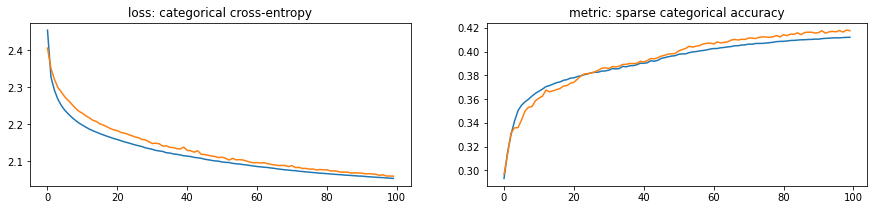

In [ ]:
print_performance(model, log_dir)
print_history(history)

## RNN followed by dense layer, with character encoding

* All built-in RNN units implemented: Simple RNN & GRU & LSTM.
* With a dense layer for the output, we can experiment with the number of units in the recurrent layers.
* Bias initialization on dense layer considering class imbalance.
* Minor tweaking of learning_rate.

In [ ]:
sequence_length = 32
batch_size = 128
dict_size = len(tokenizer.index_word.keys()) + 1
recurrent_dim = 2 * dict_size
lr_0 = .001
epochs = 100

In [ ]:
train = make_dataset('train', tokenizer, sequence_length = sequence_length, batch_size = batch_size, batching_mode = 'recurrent_encoding')
valid = make_dataset('valid', tokenizer, sequence_length = sequence_length, batching_mode = 'recurrent_encoding')
test = make_dataset('test', tokenizer, sequence_length = sequence_length, batching_mode = 'recurrent_encoding')

In [ ]:
encoding = keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = dict_size, name = "Encoding")
td_encoding = keras.layers.TimeDistributed(encoding, input_shape = [None, 1], name = "TD_Encoding")

simple_rnn = keras.layers.SimpleRNN(units = recurrent_dim, return_sequences = True, name = "Recurrent")
gru = keras.layers.GRU(units = recurrent_dim, return_sequences = True, name = "Recurrent")
lstm = keras.layers.LSTM(units = recurrent_dim, return_sequences = True, name = "Recurrent")

dense = keras.layers.Dense(units = dict_size, activation = 'softmax', name = "Dense",
                           bias_initializer = keras.initializers.Constant(bias_output_layer))

#model = keras.models.Sequential([td_encoding, simple_rnn, dense], name = "Simple_RNN_Dense_output_with_Encoding")
#model = keras.models.Sequential([td_encoding, gru, dense], name = "GRU_Dense_output_with_Encoding")
model = keras.models.Sequential([td_encoding, lstm, dense], name = "LSTM_Dense_output_with_Encoding")

model.compile(optimizer = keras.optimizers.Adam(learning_rate = lr_0), 
              loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, min_delta = .01, restore_best_weights = True, verbose = True)
log_dir = get_tensorboard_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(log_dir = log_dir)

model.summary()

Model: "LSTM_Dense_output_with_Encoding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
TD_Encoding (TimeDistributed (None, None, 116)         0         
_________________________________________________________________
Recurrent (LSTM)             (None, None, 232)         323872    
_________________________________________________________________
Dense (Dense)                (None, None, 116)         27028     
Total params: 350,900
Trainable params: 350,900
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train, epochs = epochs, verbose = 0, validation_data = valid,
                    callbacks = [early_stopping_cb, tensorboard_cb])

Restoring model weights from the end of the best epoch.
Epoch 00021: early stopping


With the use of a dense layer as the output layer and the increase in the number of units in the recurrent units, we get a significant performance improvement.

Performance on train set:
1634/1634 [==============================] - 161s 97ms/step - loss: 1.0680 - sparse_categorical_accuracy: 0.6744
Performance on valid set:
133/133 [==============================] - 3s 20ms/step - loss: 1.0350 - sparse_categorical_accuracy: 0.6822: 2s - loss: 1.0289 -
Performance on test set:
117/117 [==============================] - 2s 20ms/step - loss: 1.1011 - sparse_categorical_accuracy: 0.6649
Performance log:
run__2021-03-04__18-47-08 | LSTM_Dense_output_with_Encoding | 350900 | 1.068 1.035 1.101 | 67.4% 68.2% 66.5%


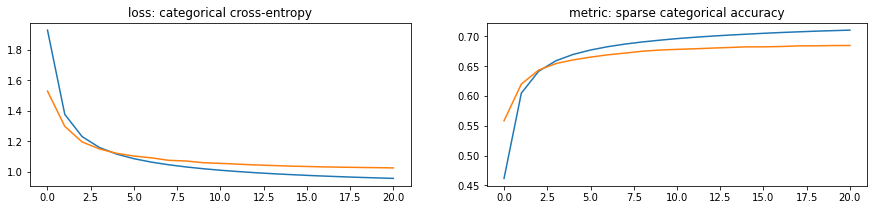

In [ ]:
print_performance(model, log_dir)
print_history(history)

## Stack of recurrent units followed by dense layer, with one-hot character encoding

* Application of a stack of 3 recurrent units.
* Implementation for all 3 built-in recurrent units (choose which one using the _type_of_recurrent_unit_ variable in the first cell).

In [ ]:
sequence_length = 32
batch_size = 128
dict_size = len(tokenizer.index_word.keys()) + 1
recurrent_dim = 2 * dict_size
recurrent_stack_size = 3
type_of_recurrent_unit = "lstm" # "simple_rnn", "gru", "lstm"
model_name = "LSTM_stack_encoding_dense"
lr_0 = .001
epochs = 100

In [ ]:
train = make_dataset('train', tokenizer, sequence_length = sequence_length, batch_size = batch_size, batching_mode = 'recurrent_encoding')
valid = make_dataset('valid', tokenizer, sequence_length = sequence_length, batching_mode = 'recurrent_encoding')
test = make_dataset('test', tokenizer, sequence_length = sequence_length, batching_mode = 'recurrent_encoding')

In [ ]:
model = keras.models.Sequential(name = model_name)

encoding = keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = dict_size, name = "Encoding")
td_encoding = keras.layers.TimeDistributed(encoding, input_shape = [None, 1], name = "TD_Encoding")

model.add(td_encoding)

for unit in range(recurrent_stack_size):
    if type_of_recurrent_unit == "simple_rnn":    
        model.add(keras.layers.SimpleRNN(units = recurrent_dim, return_sequences = True, name = "Recurrent_"+str(unit)))
    elif type_of_recurrent_unit == "gru":
        model.add(keras.layers.GRU(units = recurrent_dim, return_sequences = True, name = "Recurrent_"+str(unit)))
    elif type_of_recurrent_unit == "lstm":
        model.add(keras.layers.LSTM(units = recurrent_dim, return_sequences = True, name = "Recurrent_"+str(unit)))

dense = keras.layers.Dense(units = dict_size, activation = 'softmax', name = "Dense",
                           bias_initializer = keras.initializers.Constant(bias_output_layer))              
              
model.add(dense)

model.compile(optimizer = keras.optimizers.Adam(learning_rate = lr_0), 
              loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, min_delta = .01, restore_best_weights = True, verbose = True)
log_dir = get_tensorboard_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(log_dir = log_dir)

model.summary()

Model: "LSTM_stack_encoding_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
TD_Encoding (TimeDistributed (None, None, 116)         0         
_________________________________________________________________
Recurrent_0 (LSTM)           (None, None, 232)         323872    
_________________________________________________________________
Recurrent_1 (LSTM)           (None, None, 232)         431520    
_________________________________________________________________
Recurrent_2 (LSTM)           (None, None, 232)         431520    
_________________________________________________________________
Dense (Dense)                (None, None, 116)         27028     
Total params: 1,213,940
Trainable params: 1,213,940
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train, epochs = epochs, verbose = 0, validation_data = valid,
                    callbacks = [early_stopping_cb, tensorboard_cb])

Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping


The use of a stack of 3 recurrent units gives us another performance boost.

Performance on train set:
1634/1634 [==============================] - 512s 312ms/step - loss: 1.0596 - sparse_categorical_accuracy: 0.6738
Performance on valid set:
133/133 [==============================] - 9s 71ms/step - loss: 1.0298 - sparse_categorical_accuracy: 0.6811
Performance on test set:
117/117 [==============================] - 8s 71ms/step - loss: 1.0936 - sparse_categorical_accuracy: 0.6640
Performance log:
run__2021-03-05__18-58-16 | LSTM_stack_encoding_dense | 1213940 | 1.06 1.03 1.094 | 67.4% 68.1% 66.4%


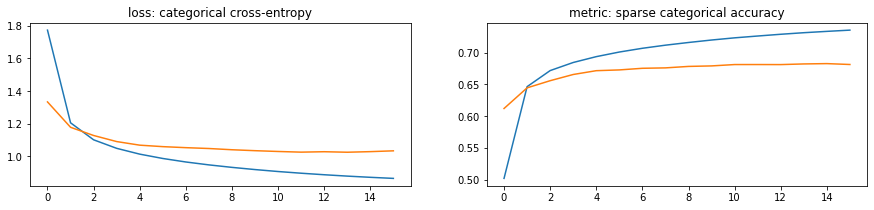

In [ ]:
print_performance(model, log_dir)
print_history(history)

## Recurrent units with layer normalization

* Model with a stack of 3 recurrent units followed by a dense layer.
* This model uses custom GRU and LSTM recurrent units (the classes are declared in a section above).
* Layer normalization stabilizes training and allows for faster learning rates as well as processing of longer text sequences with decreased risk of exploding gradients.

In [ ]:
sequence_length = 128
batch_size = 32
dict_size = len(tokenizer.index_word.keys()) + 1
recurrent_dim = 4 * dict_size
recurrent_stack_size = 3
type_of_recurrent_unit = "gru" # "simple_rnn", "gru", "lstm"
model_name = "GRU_LN_encoding_dense"
lr_0 = .001
epochs = 100
clip_norm = 1

In [ ]:
train = make_dataset('train', tokenizer, sequence_length = sequence_length, batch_size = batch_size, batching_mode = 'recurrent_encoding')
valid = make_dataset('valid', tokenizer, sequence_length = sequence_length, batching_mode = 'recurrent_encoding')
test = make_dataset('test', tokenizer, sequence_length = sequence_length, batching_mode = 'recurrent_encoding')

In [ ]:
model = keras.models.Sequential(name = model_name)

encoding = keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = dict_size, name = "Encoding")
td_encoding = keras.layers.TimeDistributed(encoding, input_shape = [None, 1], name = "TD_Encoding")

model.add(td_encoding)

for unit in range(recurrent_stack_size):
    if type_of_recurrent_unit == "simple_rnn":    
        # NOT YET IMPLEMENTED WITH LN
        model.add(keras.layers.SimpleRNN(units = recurrent_dim, return_sequences = True, name = "Recurrent_"+str(unit)))
    elif type_of_recurrent_unit == "gru":
        model.add(keras.layers.RNN(LN_GRU_Cell(units = recurrent_dim), return_sequences = True, name = "Recurrent_"+str(unit)))
    elif type_of_recurrent_unit == "lstm":
        model.add(keras.layers.RNN(LN_LSTM_Cell(units = recurrent_dim), return_sequences = True, name = "Recurrent_"+str(unit)))

dense = keras.layers.Dense(units = dict_size, activation = 'softmax', name = "Dense",
                           bias_initializer = keras.initializers.Constant(bias_output_layer))              
              
model.add(dense)

model.compile(optimizer = keras.optimizers.Adam(learning_rate = lr_0, clipnorm = clip_norm), 
              loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 2, min_delta = .01, restore_best_weights = True, verbose = True)
log_dir = get_tensorboard_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(log_dir = log_dir)

model.summary()

Model: "GRU_LN_encoding_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
TD_Encoding (TimeDistributed (None, None, 116)         0         
_________________________________________________________________
Recurrent_0 (RNN)            (None, None, 464)         811072    
_________________________________________________________________
Recurrent_1 (RNN)            (None, None, 464)         1295488   
_________________________________________________________________
Recurrent_2 (RNN)            (None, None, 464)         1295488   
_________________________________________________________________
Dense (Dense)                (None, None, 116)         53940     
Total params: 3,455,988
Trainable params: 3,455,988
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train, epochs = epochs, verbose = 1, validation_data = valid,
                    callbacks = [early_stopping_cb, tensorboard_cb])

Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping


Performance on train set:
1634/1634 [==============================] - 3223s 2s/step - loss: 1.0593 - sparse_categorical_accuracy: 0.6779
Performance on valid set:
33/33 [==============================] - 26s 783ms/step - loss: 1.0143 - sparse_categorical_accuracy: 0.6888
Performance on test set:
29/29 [==============================] - 24s 815ms/step - loss: 1.0856 - sparse_categorical_accuracy: 0.6672
Performance log:
run__2021-03-11__19-14-45 | GRU_LN_encoding_dense | 3455988 | 1.059 1.014 1.086 | 67.8% 68.9% 66.7%


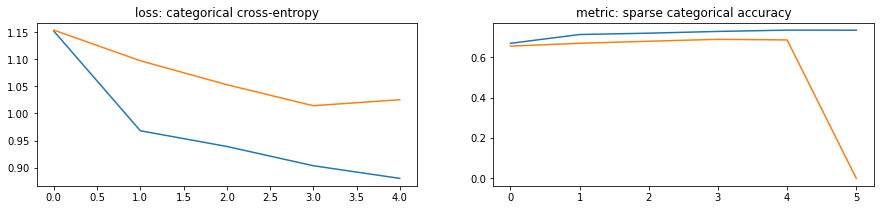

In [ ]:
print_performance(model, log_dir)
print_history(history)

## Final model: Stateful RNN, one-hot encoding, layer normalization

The final performance improvement comes from using a _stateful_ RNN architecture. This allows the network to identify patterns that are longer than the sequence size fed to the network at each optimization step. Here are the features of this model:

* Recurrent layers are created with the _stateful=True_ argument, so the memory cells are not reset after each gradient descent step.
* In order to used a _stateful_ network, the dataset needs to be split in such a way that each network instance is fed with the sequence that corresponds to that which it processed in the previous step. The dataset processing function defined in the beginning of the notebook is setup as such.
* A _ReduceLROnPlateau_ callback is carefully tuned to reduce the learning rate at approapriate moments during the training process so that learning is more precise in the intermediate and final stages of training.
* Dropout rates are selected to provide a regularization effect and reduce overfitting.
* After a lot of experimentation, GRU show better performance and robustness to larger learning rates.
* The batch size and sequence length are selected to allow for faster training, ability to identify longer patterns, and capacity to fit into the available memory.

In [ ]:
tf.random.set_seed(20210228)
sequence_length = 512
batch_size = 64
dict_size = len(tokenizer.index_word.keys()) + 1
recurrent_dim = 5 * dict_size
recurrent_stack_size = 3
dropout = .10
recurrent_dropout = .05
type_of_recurrent_unit = "gru" # "simple_rnn", "gru", "lstm"
model_name = "Stateful_GRU_LN_encoding_dense"
lr_0 = .001
epochs = 100
clip_norm = None

In [ ]:
train = make_dataset('train', tokenizer, sequence_length = sequence_length, batch_size = batch_size, batching_mode = 'stateful_encoding')
valid = make_dataset('valid', tokenizer, sequence_length = sequence_length, batching_mode = 'stateful_encoding')
test = make_dataset('test', tokenizer, sequence_length = sequence_length, batching_mode = 'stateful_encoding')

In [ ]:
model = keras.models.Sequential(name = model_name)

encoding = keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens = dict_size, name = "Encoding")
td_encoding = keras.layers.TimeDistributed(encoding, input_shape = [None, 1], name = "TD_Encoding")

model.add(td_encoding)

for unit in range(recurrent_stack_size):
    if type_of_recurrent_unit == "simple_rnn":    
        # NOT YET IMPLEMENTED WITH LN
        model.add(keras.layers.SimpleRNN(units = recurrent_dim, return_sequences = True, name = "Recurrent_"+str(unit)))
    elif type_of_recurrent_unit == "gru":
        model.add(keras.layers.RNN(LN_GRU_Cell(units = recurrent_dim, dropout = dropout, recurrent_dropout = recurrent_dropout), 
                                   return_sequences = True, name = "Recurrent_"+str(unit)))
    elif type_of_recurrent_unit == "lstm":
        model.add(keras.layers.RNN(LN_LSTM_Cell(units = recurrent_dim, dropout = dropout, recurrent_dropout = recurrent_dropout), 
                                   return_sequences = True, name = "Recurrent_"+str(unit)))

dense = keras.layers.Dense(units = dict_size, activation = 'softmax', name = "Dense",
                           bias_initializer = keras.initializers.Constant(bias_output_layer))              
              
model.add(dense)

model.compile(optimizer = keras.optimizers.Nadam(learning_rate = lr_0, clipnorm = clip_norm), 
              loss = 'sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience = 100, min_delta = 0, restore_best_weights = True, verbose = True)
plateau_cb = keras.callbacks.ReduceLROnPlateau(monitor = 'loss', min_delta = .01, patience = 3, factor = .3, cooldown = 30, verbose = 1)
terminate_on_nan_cb = keras.callbacks.TerminateOnNaN()
log_dir = get_tensorboard_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(log_dir = log_dir)

model.summary()

Model: "Stateful_GRU_LN_encoding_dense"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
TD_Encoding (TimeDistributed (None, None, 116)         0         
_________________________________________________________________
Recurrent_0 (RNN)            (None, None, 580)         1215680   
_________________________________________________________________
Recurrent_1 (RNN)            (None, None, 580)         2023040   
_________________________________________________________________
Recurrent_2 (RNN)            (None, None, 580)         2023040   
_________________________________________________________________
Dense (Dense)                (None, None, 116)         67396     
Total params: 5,329,156
Trainable params: 5,329,156
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(train, epochs = epochs, verbose = 1, validation_data = valid,
                    callbacks = [early_stopping_cb, tensorboard_cb, terminate_on_nan_cb, plateau_cb])

Epoch 1/100
204/204 [==============================] - 531s 2s/step - loss: 2.5602 - sparse_categorical_accuracy: 0.3290 - val_loss: 1.1567 - val_sparse_categorical_accuracy: 0.6530
Epoch 2/100
204/204 [==============================] - 481s 2s/step - loss: 1.4576 - sparse_categorical_accuracy: 0.5747 - val_loss: 0.9509 - val_sparse_categorical_accuracy: 0.7081
Epoch 3/100
204/204 [==============================] - 474s 2s/step - loss: 1.1523 - sparse_categorical_accuracy: 0.6559 - val_loss: 0.8718 - val_sparse_categorical_accuracy: 0.7301
Epoch 4/100
204/204 [==============================] - 473s 2s/step - loss: 1.0172 - sparse_categorical_accuracy: 0.6925 - val_loss: 0.8210 - val_sparse_categorical_accuracy: 0.7455
Epoch 5/100
204/204 [==============================] - 474s 2s/step - loss: 0.9495 - sparse_categorical_accuracy: 0.7112 - val_loss: 0.7869 - val_sparse_categorical_accuracy: 0.7568
Epoch 6/100
204/204 [==============================] - 473s 2s/step - loss: 0.9061 - spars

The improvements in this model provide a major performance boost, with over 82% accuracy in the validation and test sets.

Performance on train set:
204/204 [==============================] - 99s 439ms/step - loss: 0.4369 - sparse_categorical_accuracy: 0.8632
Performance on valid set:
7/7 [==============================] - 3s 422ms/step - loss: 0.5882 - sparse_categorical_accuracy: 0.8212
Performance on test set:
7/7 [==============================] - 3s 446ms/step - loss: 0.5766 - sparse_categorical_accuracy: 0.8264
Performance log:
/content/tb_logs/run__2021-03-26__19-10-36 | Stateful_GRU_LN_encoding_dense | 5329156 | 0.437 0.588 0.577 | 86.3% 82.1% 82.6%


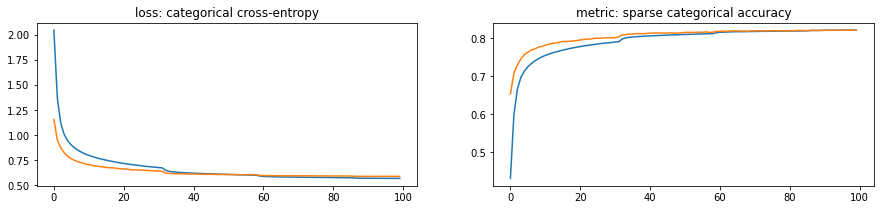

In [ ]:
print_performance(model, log_dir)
print_history(history)

# Inference and model persistence

In this section, we save the model and use it to create new text sequences.

## Save model

The code below saves the model in the .h5 file format.

In [ ]:
file_name = 'model___' + log_dir.replace(join(getcwd(),'tb_logs',''), '') + '___' + model_name + '.h5'
if 'models' not in listdir():
    mkdir('models')
model.save(join(getcwd(), 'models', file_name))

In [ ]:
file_name = 'tokenizer___' + log_dir.replace(join(getcwd(),'tb_logs',''), '') + '___' + model_name + '.json'

with open(join(getcwd(), 'models', file_name), 'wb') as file:
    pickle.dump(tokenizer, file)

## Text generator

This section uses the recently trained model to create original text.

The _convert_to_inference_model_ function receives a model as argument and returns a version with _stateful_ set to _True_. The application of this function is not necessary for the final model (which was created and trained in this setup), but is important for the use of all the previous versions.

In [ ]:
def convert_to_inference_model(original_model, custom_objects=None):
    original_model_json = original_model.to_json()
    inference_model_dict = json.loads(original_model_json)

    layers = inference_model_dict['config']['layers']
    for layer in layers:
        if 'stateful' in layer['config']:
            layer['config']['stateful'] = True

        if 'batch_input_shape' in layer['config']:
            layer['config']['batch_input_shape'][0] = 1
            layer['config']['batch_input_shape'][1] = None

    inference_model = keras.models.model_from_json(json.dumps(inference_model_dict), custom_objects = custom_objects)
    inference_model.set_weights(original_model.get_weights())

    return inference_model

This code applies the function above to the model, and creates a stateful version for inference.

In [ ]:
inference_model = convert_to_inference_model(model, custom_objects = {'LN_GRU_Cell':LN_GRU_Cell, 'LN_LSTM_Cell':LN_LSTM_Cell})

This section of code generates a new sequence of characters. Because the model is set to _stateful=True_, we can feed the model with a seed text (in this case, the section character) and use it to generate probabilities for the following character. We then randomly select a new character according to the predicted probabilities, add it to the text, and feed the text back into the inference model.

In [ ]:
length_generated_text = 10000
file_name = ('generated_text___' + log_dir.replace(join(getcwd(),'tb_logs',''), '') + 
             '___' + model_name + '___' + time.strftime("%Y-%m-%d__%H-%M-%S") + '.txt')
directory = 'generated_text'

text = '§'
sequence = tokenizer.texts_to_sequences([text])

for _ in range(length_generated_text):
    probs = inference_model.predict(np.array(sequence[0][-1]).reshape(1,-1,1))
    token = np.random.choice(np.arange(dict_size), p = probs[0,-1,:])
    sequence[0].append(token)

text = tokenizer.sequences_to_texts(sequence)[0]    
print(text[0:np.min([2000, length_generated_text]):2])

if directory not in listdir():
    mkdir(directory)

with open(join(getcwd(), 'generated_text', file_name), 'w', encoding='utf-8') as file:
    file.write(text[0::2])

§ 21.199 of this chapter. 
(2) Procedures for the deviations from paragraph (a) of this section is added to the operations specifications in paragraph (a) of this section. (1) Any requirement of this section unless the requirements of paragraph (c)(2) of this section will be completed by an effective date of the operations of the aircraft or the route before a small unmanned aircraft is 500 kg logs at 86 parachute mile, at least 15 feet in length and quantities associated with any week only unless there is at least three tank at altitudes where crewmembers apply to cargo and baggage compartments or series (19 genteral design. 


§ 29.1527   Rotor brake container - The suitability and durability of radio communication equipment requirements.The pilot in command must extinguishing overspeed overtemperature, over 10 minutes, in which the engine is designed, complies with the applicable ramaining requirements for its conditions. VF and maximum allowable speed, altitude, and temperature ind

A detailed discussion of the results and the properties of the generated text is available at [this blog post](https://fabio-a-oliveira.github.io/2021-04-01_14-CFR-FAA.html). A file with 1 million characters generated with the model is found at [this link](https://raw.githubusercontent.com/fabio-a-oliveira/14-CFR-FAA/main/generated_text/generated_text___1000000_chars__2021-03-27__21-15-26.txt).